In [18]:
import h5py
import numpy as np
import cv2

from PIL import Image
from IPython.display import display

In [3]:
def softmax(x):
    return np.exp(x)/np.expand_dims(np.sum(np.exp(x),axis=-1),-1)

def draw_hulls(image):
    contours,_ = cv2.findContours(image.astype(np.uint8),2,1)
    cnt = contours[-1]
    defects = cv2.convexityDefects(
        cnt, cv2.convexHull(cnt,returnPoints = False))
    if defects is not None:
        defects = defects[defects[:,0,-1]>2000,:,:]
        if defects.size > 0:
            for defect in defects:
                a = tuple([x for x in cnt[defect[0,0],0,:]])
                b = tuple([x for x in cnt[defect[0,1],0,:]])
                output = cv2.line(image.astype(np.uint8),a,b,1)
                output = binary_fill_holes(output)
        else:
            output = image
    else:
        output = image
    return output,cnt

def filter_refine_cell(image_labels_im_i):
    F_size = 9
    Filter = np.ones([F_size,F_size]) / (F_size**2)
    image,labels_im,i,rs = image_labels_im_i
    s = 128
    s_2 = s // 2
    sh = image.shape
    x,y = np.where(labels_im == i)
    R = x.min(),y.min(),x.max(),y.max()
    cx,cy = int((R[2]+R[0])/2),int((R[3]+R[1])/2)
    sx,sy = R[2]-R[0],R[3]-R[1]
    cc = [cx-s_2,cy-s_2]
    cc.extend([cc[0]+s,cc[1]+s])
    features = None
    conditions = [
        cc[0]<0,cc[1]<0,cc[2]>sh[0],cc[3]>sh[1],
        sx > 120,sy > 120]
    if np.any(conditions):
        x_ = x - cc[0]
        y_ = y - cc[1]
        S = len(x)
        if S < 8000/rs:
            sub_image = image[cc[0]:cc[2],cc[1]:cc[3],:]
            mask_binary_holes = np.zeros([s,s])
            mask_binary_holes[(x_,y_)] = 1
            mask_convolved = convolve_n(
                mask_binary_holes.astype(np.float32),
                Filter,3,thr=0.5)
            mask_hulls,cnt = draw_hulls(mask_convolved)
            mask_hulls = binary_fill_holes(mask_hulls)
            features = {}
            features['image'] = sub_image
            features['mask'] = mask_hulls
            features['cnt'] = cnt
            features['x'] = x
            features['y'] = y
    else:
        x_ = x - cc[0]
        y_ = y - cc[1]
        S = len(x)
        if (S > 1000/rs) and (S < 8000/rs):
            sub_image = image[cc[0]:cc[2],cc[1]:cc[3],:]
            mask_binary_holes = np.zeros([s,s])
            mask_binary_holes[(x_,y_)] = 1
            mask_convolved = convolve_n(
                mask_binary_holes.astype(np.float32),
                Filter,3,thr=0.5)
            mask_hulls,cnt = draw_hulls(mask_convolved)
            mask_hulls = binary_fill_holes(mask_hulls)
            features = {}
            features['image'] = sub_image
            features['mask'] = mask_hulls
            features['cnt'] = cnt
            features['x'] = x
            features['y'] = y
    return features

def refine_prediction_wbc(image,mask,rs):
    mask_binary = apply_hysteresis_threshold(mask,0.5,0.5)
    mask_binary = np.where(mask > 0.5,1,0)
    mask_binary_holes = binary_fill_holes(mask_binary)

    num_labels, labels_im = cv2.connectedComponents(
        np.uint8(mask_binary_holes))

    output = np.zeros(mask_binary_holes.shape,dtype=np.uint8)
    if num_labels > 1:
        for i in range(1,num_labels):
            features = filter_refine_cell([image,labels_im,i,rs])
            if features is not None:
                x,y = features['x'],features['y']
                output[x,y] = 1
    
    return output

In [4]:
prediction_files = {
    'Adden1':h5py.File("dataset/prediction_adden_1.h5",'r'),
    'Adden2':h5py.File("dataset/prediction_adden_2.h5",'r'),
    'MLL':h5py.File("dataset/prediction_mll.h5",'r')
}

Iron 12_70490_33559.png


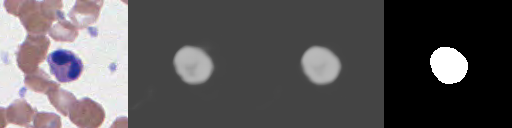

Iron 12_78938_11022.png


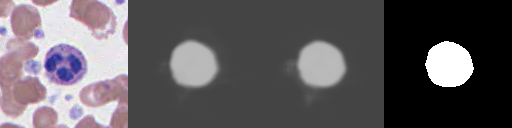

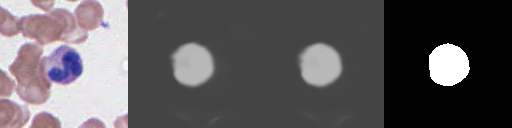

Iron 13_22675_38471.png


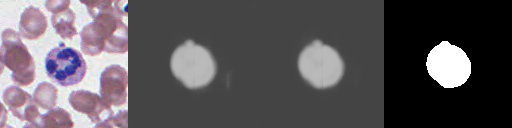

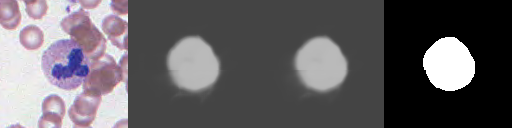

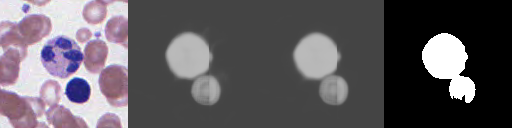

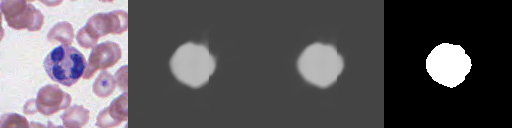

Iron 13_23316_8276.png


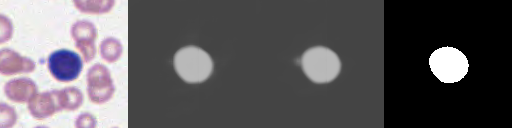

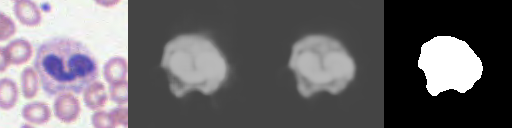

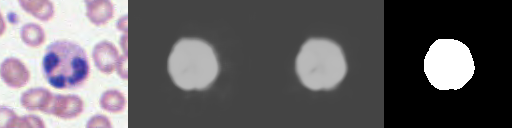

Iron 2_115668_40614.png


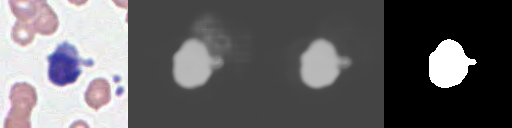

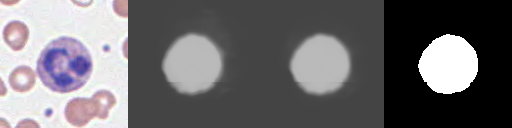

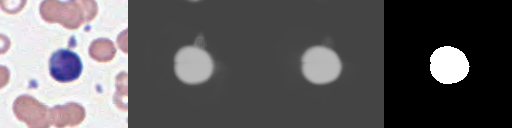

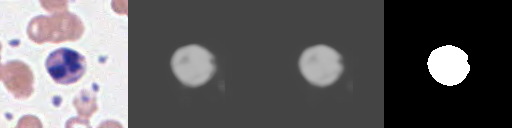

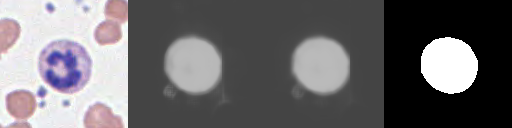

Iron 4_94936_64081.png


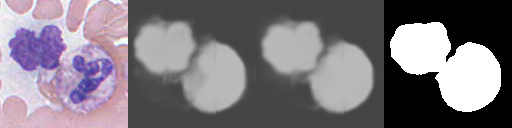

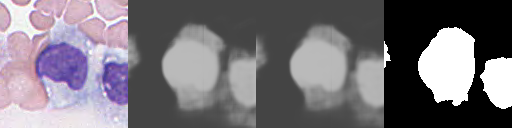

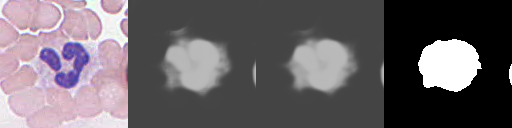

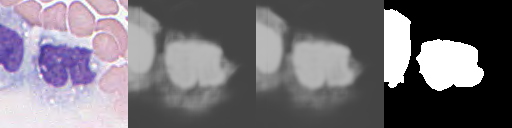

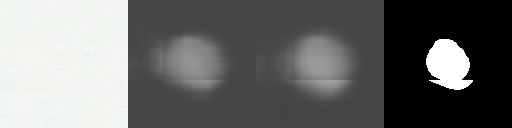

Iron 5_68290_39706.png


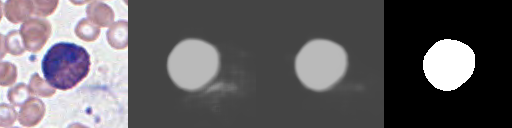

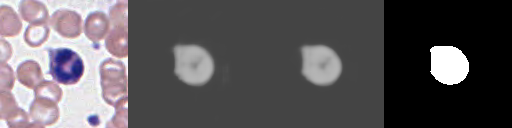

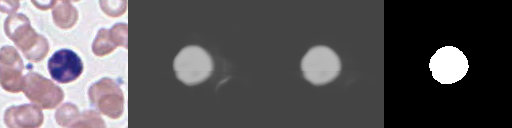

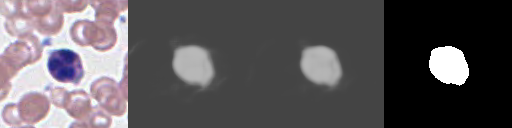

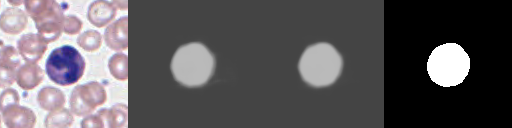

Iron 7_73406_62161.png


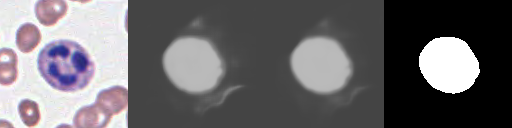

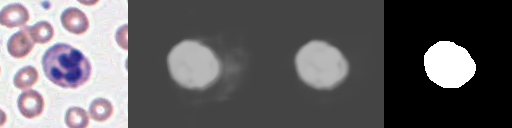

Normal N2_85596_12476.png


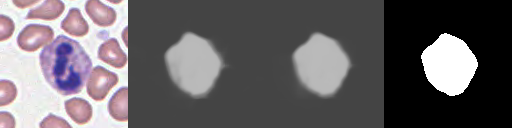

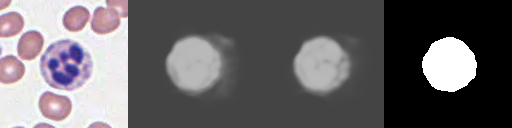

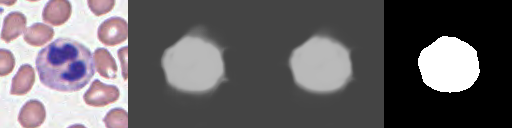

Normal N4_82328_35211.png


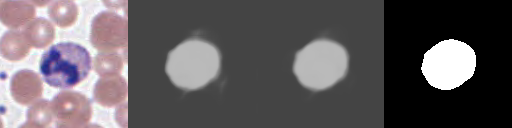

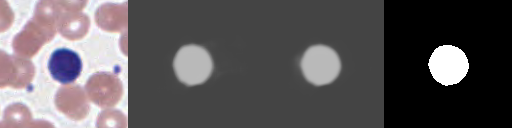

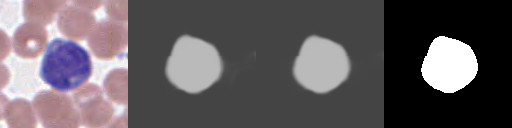

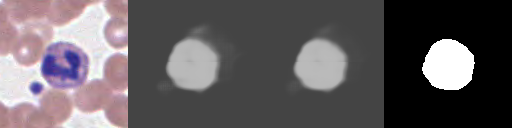

Normal N8_31714_3190.png


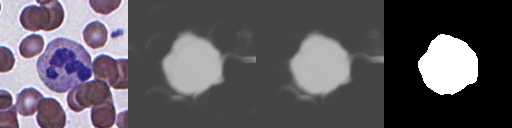

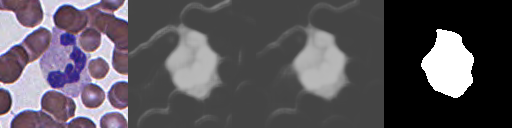

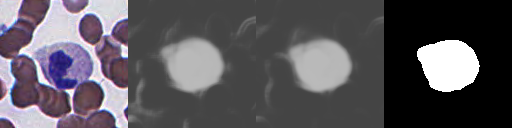

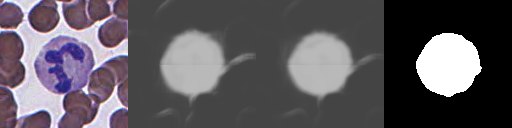

Normal N8_75920_20283.png
SF3B1 10#2_2184_14999.png


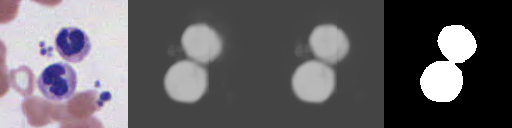

SF3B1 10#2_40043_25189.png


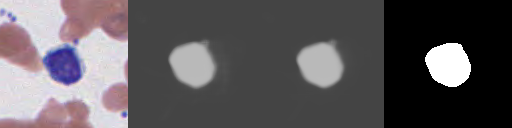

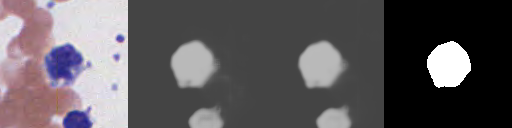

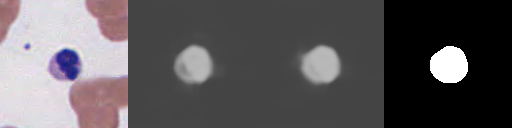

SF3B1 14B_21570_73882.png


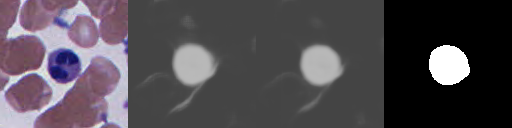

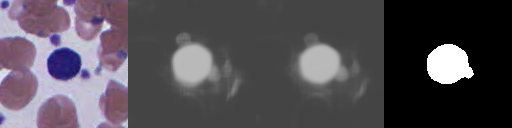

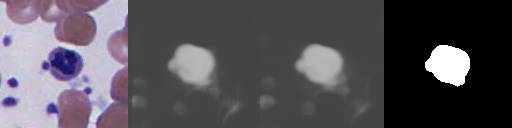

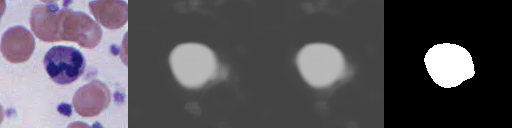

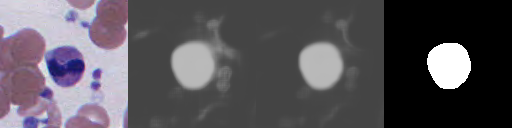

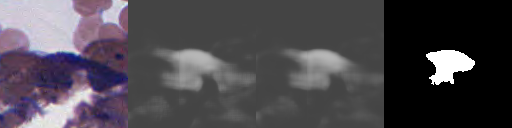

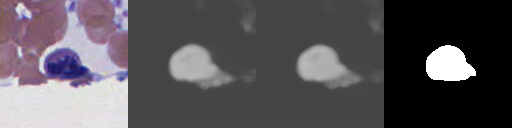

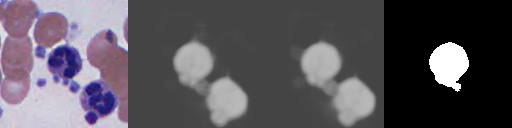

SF3B1 14B_77572_44020.png


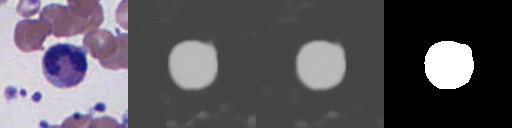

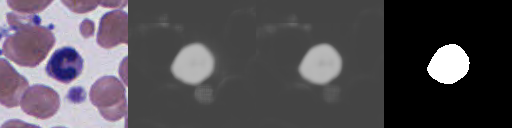

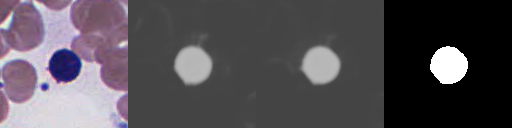

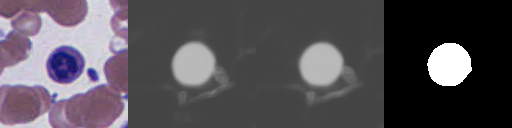

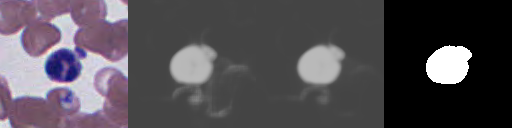

SF3B1 3_33811_71897.png


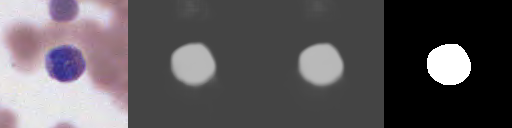

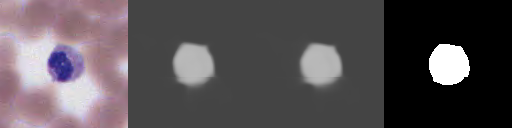

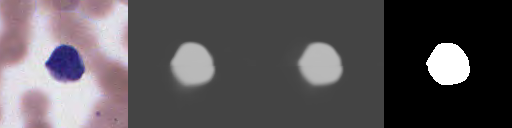

SF3B1 6 RPT_91107_5475.png


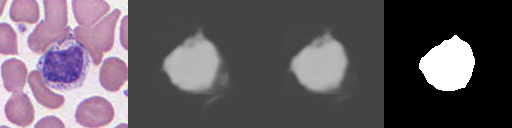

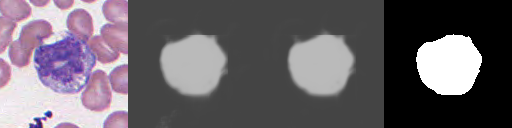

SF3B1 8 RPT_52100_18070.png


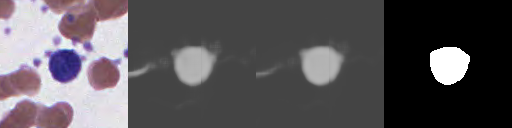

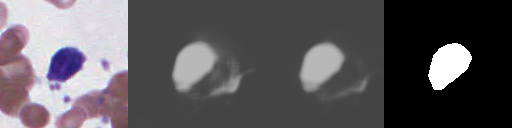

SF3B1 9#2B_37141_11404.png


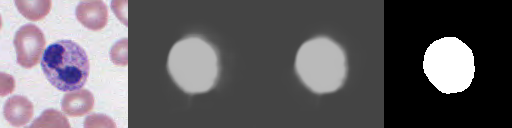

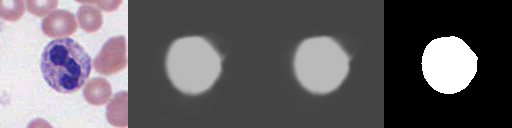

SRSF2 1_43468_86474.png


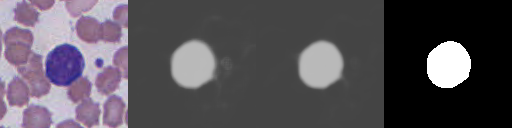

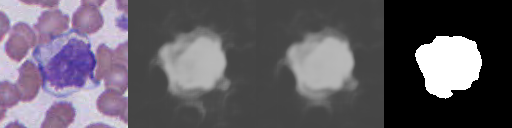

SRSF2 2_10377_5157.png
SRSF2 2_40592_5133.png
SRSF2 8_20909_70884.png


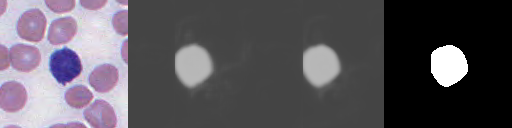

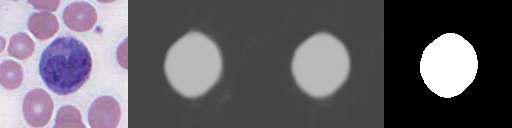

SRSF2 8_28391_71652.png


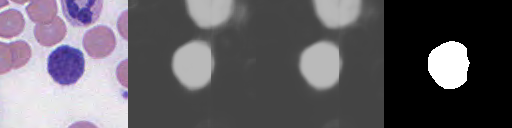

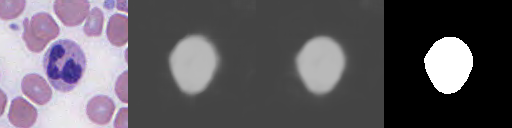

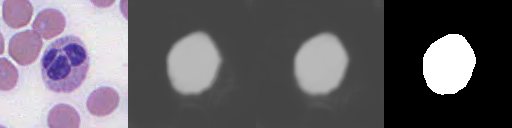

SRSF2 8_2942_34485.png


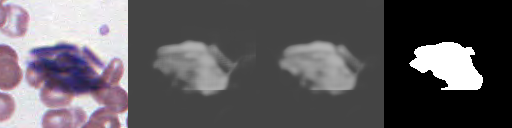

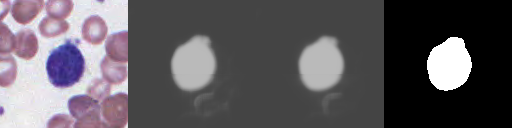

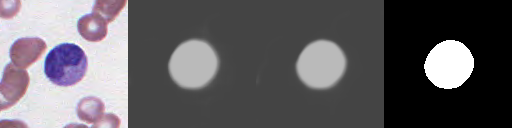

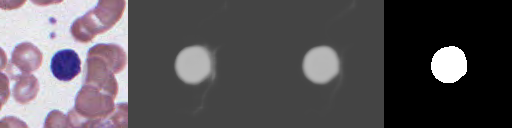

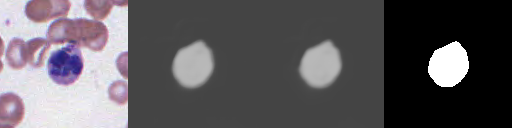

In [38]:
hs = 64

dataset_id = 'Adden2'

for k in prediction_files[dataset_id]:
    print(k)
    image = prediction_files[dataset_id][k]['image'][()]
    prediction = softmax(prediction_files[dataset_id][k]['prediction'][()])
    prediction_tta = softmax(prediction_files[dataset_id][k]['prediction_tta'][()])
    prediction_tta_refine = prediction_files[dataset_id][k]['prediction_tta_refine'][()]
    
    image = np.uint8(image * 255)
    prediction = np.uint8(softmax(prediction)[:,:,1] * 255)
    prediction_tta = np.uint8(softmax(prediction_tta)[:,:,1] * 255)
    prediction_tta_refine = np.uint8(prediction_tta_refine * 255 * 255)
    prediction_tta_refine = np.where(
        prediction_tta_refine > 0, 255, 0).astype(np.uint8)
    
    n_c,cc = cv2.connectedComponents(prediction_tta_refine)
        
    for c in range(1,n_c):
        x,y = np.where(cc == c)
        cx,cy = x.mean(),y.mean()
        x_1,y_1 = int(cx - hs),int(cy - hs)
        x_2,y_2 = int(x_1 + hs*2),int(y_1 + hs*2)
        
        sub_image = image[x_1:x_2,y_1:y_2,:]
        sub_prediction = prediction[x_1:x_2,y_1:y_2]
        sub_prediction_tta = prediction_tta[x_1:x_2,y_1:y_2]
        sub_prediction_tta_refine = prediction_tta_refine[x_1:x_2,y_1:y_2]
        
        display_image = np.concatenate([
            sub_image,
            np.stack([sub_prediction for _ in range(3)],axis=2),
            np.stack([sub_prediction_tta for _ in range(3)],axis=2),
            np.stack([sub_prediction_tta_refine for _ in range(3)],axis=2)
        ],axis=1)
        
        display(Image.fromarray(display_image))